## CS109a Final Project - Spotify Recommendation System
Group \#55: Nick Kochanek, Jack Connolly, Chris Jarrett, Andrew Soldini

**Project Goal:**  
Our goal for this project was to develop a system that could recommend reasonable songs to continue a playlist give a certain number of "seed" tracks. We formalized this task as giving a model a list of $K$ input songs (as Spotify uris) and having the model output $500$ suggested uris (ideally ranked by relevance). This falls in line with the formal specifications for the Spotify RecSys challenge, and allows us to compare results and approaches with top teams there. As such, we decided to evaluate our models using the same metrics the contest was based on, which will be described further on.

In [1]:
import requests

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [5]:
import json, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import pickle

pd.options.mode.chained_assignment = None

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import *

/Library/anaconda/envs/cs109/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
Using TensorFlow backend.


### Loading in the data (Million Playlist Dataset)

In [3]:
# After running into issues trying to pickle large objects (ie our graph), 
# It turns out that there's an issue in the pickle implementation. This stack overflow function 
# allows for easy saving of big objects 
# https://stackoverflow.com/questions/42653386/does-pickle-randomly-fail-with-oserror-on-large-files
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

In [ ]:
# This is the code from 'build_network.py'

# 14 is a lot (the biggest we were able to run) 
# Use only like < 5 to finish in a reasonable time
NUMBER_OF_FILES_TO_USE = 10

"""
The code below builds the network
It also builds relevant objects to use for the other models
"""
song_name_to_uri, uri_to_song_name = {}, {}
track_to_artist_album, network = {}, {}

track_codes = set()
playlists, uri_input, uri_expected = [], [], []

K = 10

f_start = 1000
f_end = 1999
for i in range(NUMBER_OF_FILES_TO_USE): 
    data_path = 'large_files/'
    # data_path = './mpd.v1/data/'
    with open(data_path + 'mpd.slice.{}-{}.json'.format(f_start, f_end)) as f: 
        data = json.load(f)
        
    input_, expected = [], []
    for playlist in data['playlists']:
        playlist_dict = playlist.copy()
        playlist_dict.pop('tracks', None)

        for k, song in enumerate(playlist['tracks']): 
            track_name  = song['track_name']
            track_uri = song['track_uri']
            shared_songs = np.array([s['track_uri'] for s in playlist['tracks'] if s['track_uri'] != track_uri])
                
            if track_uri not in track_codes:
                track_codes.add(track_uri)
                track_to_artist_album[track_uri] = {'artist': song['artist_name'], 'album': song['album_name']}
                uri_to_song_name[track_uri] = track_name
            
            if track_name not in song_name_to_uri: 
                song_name_to_uri[track_name] = track_uri

            if track_uri not in network: 
                network[track_uri] = np.array(shared_songs)
            else: 
                network[track_uri] = np.append(network[track_uri], np.array(shared_songs))
                
            if k < K:
                input_.append(track_uri)
            else:
                expected.append(track_uri)
                
        playlists.append(playlist_dict)
        uri_input.append(input_)
        uri_expected.append(expected)
                
    print ("done loading file", i)             
    f_start += 1000
    f_end += 1000
    
    
# Clean the network -> counts per song (normalized)
print("Cleaning up the Network a bit")
for uri in network : 
    unique, counts = np.unique(network[uri], return_counts=True)
    network[uri] = {'songs' : unique, 'counts': counts / np.sum(counts)}
    
    
# Save all of the objects as pickles
save_as_pickled_object(network, 'pickled_network.pickle')

with open('songs_to_uri.pickle', 'wb') as f:
    pickle.dump(song_name_to_uri, f)

with open('uri_to_song.pickle', 'wb') as f:
    pickle.dump(uri_to_song_name, f)

with open('track_to_artist_album.pickle', 'wb') as f:
    pickle.dump(track_to_artist_album, f)

### Getting audio features from the Spotify API
This takes awhile - you can just load to saved pickles 'audio_features.pickle' and 'uris_10.pickle' below.

In [7]:
with open('./cs109_final_backend/cs109_final_backend/cluster_files/uris_10.pickle', 'rb') as f:
    URIS_SET = pickle.load(f)

In [ ]:
from spotipy.oauth2 import SpotifyClientCredentials

cid ="1b81d49177e5464781a4957e5e0c1ae6" 
secret = "c444a35689e247f8b5f9830662bae244" 
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False 

uris = list(URIS_SET)
spotify = spotipy.Spotify(auth='BQDuG3_3-tAv09LQlZKwYc-oodCcDdau9O-I-Ep_O6IK-Uqvc5S3FKwdr5qtVu5Kq1khJCwkeaR9PnQJjvL6fBRPWdjJ9H_KRoGCrSlMP5DjdcLMlWJybPF1VvJDuSwBpoxiLS_Qmr9R4z-RoDWDPNiZnlzCeJNxMMvLRg')

keys_to_remove = ["duration_ms", "type", "id", "uri", "track_href", "analysis_url"]

start = 0
audio_features = []
while start < len(uris):
    response = sp.audio_features(uris[start:(100+start)])
    small_response = []
    for track in response:
        if track is not None:
            small_dict = {key:track[key] for key in track.keys() - keys_to_remove}
        else:
            print('here')
            small_dict = {key:0.0 for key in response[0].keys() - keys_to_remove}
        small_response.append(small_dict)

    audio_features.extend(small_response)
        
    start += 100
    if start % 1000 == 0: print(start)

audio_df = pd.DataFrame(audio_features)


# Save the pickles
with open('uris_10.pickle', 'wb') as handle:
    pickle.dump(uris, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('audio_features.pickle', 'wb') as handle:
    pickle.dump(audio_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# Load the pickles instead of rescraping
with open('uris_10.pickle', 'rb') as f:    
    uris = pickle.load(f)
with open('audio_features.pickle', 'rb') as f:    
    audio_features = pickle.load(f)
        
audio_df = pd.DataFrame(audio_features)

print(len(uris))
print(len(audio_df))

170380
170380


#### Train Test Split:
As well as scaling so KNN and KMeans is meaningful

In [12]:
#X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(uri_input, uri_expected, test_size=.2, random_state=41)

# Scale the features in audio_df to mean=0 and variance=1
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
audio_scaled = ss.fit_transform(audio_df)

print(len(uris))
print(len(audio_scaled))

audio_dict = {}
for i in range(len(uris)):
    audio_dict[uris[i]] = audio_scaled[i]

170380
170380


### Data and EDA
The data sources we utilized in our explorations were the Million Playlist Dataset and the Spotify API. The MPD gave us the essential data to train models on subsets of playlists and evaluate the accuracy of our predictions. We used to Spotify API to get pre-computed audio features for songs, which allowed us to expore alternative model choices more in line with what we looked at in class. 

In [ ]:
names = list(track_counts.keys())
counts = list(track_counts.values())

num_files = 20
percent_data = (num_files / 1000) * 100

plt.plot(range(len(names)), counts)
plt.xlabel('Songs')
plt.ylabel('# of Times it Appears')
plt.title(f'Counts for each song that appears in the first {percent_data}% of the data')
plt.show()

In [ ]:
# More graphs and charts, both for MPD and for Spotify audio features

## Models

We explored a variety of different models and model types, but because the style of problem was different than those we studied in class, we were forced to explore different techniques than those we had seen. Our baseline models use a combination of KMeans Clustering and/or KNN, while the top two performing models are a Markov Walk on a Network and Collaborative Filtering.

### Baseline: Song Based KMeans Clustering and KNN

In [ ]:
# Cluster songs and build:
# - dict with list of URIs for each cluster
# - dict with each song mapped to its cluster
n_clusters = 75
km_songs = KMeans(n_clusters=n_clusters)
song_clusters = km_songs.fit_predict(audio_scaled)

cluster_to_songs, song_to_cluster = {}, {}
for i, cluster_num in enumerate(song_clusters):
    if cluster_num not in cluster_to_songs:
        cluster_to_songs[cluster_num] = []
        
    cluster_to_songs[cluster_num].append(uris[i])
    song_to_cluster[uris[i]] = cluster_num
    
# Save the pickles
with open('cluster_to_songs.pickle', 'wb') as handle:
    pickle.dump(cluster_to_songs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('song_to_cluster.pickle', 'wb') as handle:
    pickle.dump(song_to_cluster, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
# Load Pickles
cluster_prefix = './cs109_final_backend/cs109_final_backend/cluster_files/'
with open(cluster_prefix + 'song_to_cluster.pickle', 'rb') as f:    
    song_to_cluster = pickle.load(f)
with open(cluster_prefix + 'cluster_to_songs.pickle', 'rb') as f:    
    cluster_to_songs = pickle.load(f)

**Explanation**:  
This clustering model is very much a baseline for the other models. Intuitively, it clusters all songs then for each input of seed songs, finds an the 'closest' songs to those, in some way. They all use the Spotify API audio features to cluster and make predictions, relatively ignoring the MPD aside as input and output uris. The following class has three different predict methods, namely `predict`, `predict2`, and `predict3`. The first simply calculates the most populous cluster among the input data, then randomly samples 500 songs from that cluster. The second tries to match the distribution of input songs more closely, outputting the number of songs in the input per cluster scaled up for a total of 500. Finally, the last method uses the audio features even more, calculating the 'distance' of every song in the same cluster to the 'average' of the input songs, outputting the 500 songs closest to the average in order. Overall, these methods do fairly poorly at matching the held out songs, only retrieving relevant songs fairly rarely. The R-precision of these methods is in the range of 0.005-0.011.

In [17]:
class ClusterModel:
    def __init__(self, cluster_to_song, song_to_cluster, audio_dict=None, K=25):
        self.name = 'cluster_model'
        self.cluster_to_song = cluster_to_song
        self.song_to_cluster = song_to_cluster
        self.K = K
        self.audio_dict = audio_dict
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for playlist in X:
            clusters = [self.song_to_cluster[song] for song in playlist if song in self.song_to_cluster]
            unique, counts = np.unique(clusters, return_counts=True)
            max_cluster_id = unique[np.argmax(counts)]
            max_cluster = self.cluster_to_song[max_cluster_id]
            try:
                predicted = np.random.choice(max_cluster, size=500, replace=False)
            except ValueError:
                predicted = max_cluster
            predictions.append(predicted)
        return predictions
    
    def predict2(self, X):
        predictions = []
        for playlist in X:
            clusters = [self.song_to_cluster[song] for song in playlist if song in self.song_to_cluster]
            unique, counts = np.unique(clusters, return_counts=True)
            predicted = []
            for cl, count in zip(unique, counts):
                size = count * (500 // self.K)
                cluster = self.cluster_to_song[cl]
                preds = np.random.choice(cluster, size=size, replace=False)
                predicted.extend(preds)
            predictions.append(predicted)
        return predictions
    
    def predict3(self, X):
        assert(self.audio_dict is not None)
        predictions = []
        for playlist in X:
            clusters = [self.song_to_cluster[song] for song in playlist if song in self.song_to_cluster]
            unique, counts = np.unique(clusters, return_counts=True)
            max_cluster_id = unique[np.argmax(counts)]
            max_cluster = self.cluster_to_song[max_cluster_id]
            
            avg_feat = self.get_average_features(playlist)
            distances = [(uri, self.distance(avg_feat, self.audio_dict[uri])) for uri in max_cluster]
            distances.sort(key=lambda tup: tup[1])
            
            predictions.append([uri for uri, _ in distances[:500]])
        return predictions
    
    def get_average_features(self, playlist):
        average_features = None
        for uri in playlist:
            features = self.audio_dict[uri]
            if average_features is None:
                average_features = features
            else:
                average_features = average_features + features
        average_features = average_features / len(playlist)
        return average_features
    
    def distance(self, audio1, audio2):
        distance = np.sqrt(np.sum((audio1 - audio2) ** 2.0))
        return distance

### Another baseline: Playlist Based KNN

In [ ]:
# Playlist Based KNN (Chris)

### Collaborative Filtering

In [ ]:
# Filtering code here (Chris)

### Network Based Markov Model
This model is a probabilistic one that builds up a network where each vertex represents a song and each edge represents two song sharing a playlist (where more shared playlists leads to higher weighting). Then for prediction, for each of the input $K$ songs, many one step random walks are taken, and the most popular songs that show up in these walks are then returned as a list of 500 song recommendations (after getting rid of duplicates that are already in the playlist). This model consistently performed the best of our models, although building up a large network takes a significant amount of time and space.

In [34]:
# Network Building code

NETWORK_FILE_PATH = './cs109_final_backend/cs109_final_backend/network_files/pickled_network.pickle'

with open(NETWORK_FILE_PATH, 'rb') as f: 
    NETWORK = pickle.load(f)
    
def n_top_songs(playlist_songs, network, num_samples=4000, num_top_songs=100): 
    key_errors = 0
    all_samples = np.array([])
    for song_uri in playlist_songs: 
        try : 
            sample = np.random.choice(network[song_uri]['songs'], num_samples, p=network[song_uri]['counts'])
            all_samples = np.append(all_samples, sample)
        except KeyError: 
            key_errors += 1
    
    unique, counts = np.unique(all_samples, return_counts=True)
    
    counts = counts.astype(float) / np.sum(counts)
    counted_samples = zip(unique, counts)
    counted_samples = [sample for sample in counted_samples if sample[0] not in playlist_songs]
    counted_samples = sorted(counted_samples, key=lambda x: x[1], reverse=True)
    
    num_to_return = min(num_top_songs, len(counted_samples))

    return counted_samples[:num_to_return]

In [35]:
def evaluate_network_accuracy(train, test, network, num_predictions=500): 
    print ("starting with {} songs, and trying to find {} songs".format(len(train), len(test)))
    preds = n_top_songs(train, network, num_top_songs = num_predictions)
    preds = [p[0] for p in preds]
    correct_ratio = len([x for x in preds if x in test])/(1. * len(test))
    print(correct_ratio)
    return correct_ratio

## Evaluation
We decided to evaluate our models based on the same metrics used in the Spotify RecSys [contest rules](https://recsys-challenge.spotify.com/rules), namely R-Precision (RPrec), Normalized Discounted Cumulative Gain (NDCG), and Recommended Song Clicks (RSC). In the following definitions, $G$ is the set of ground truth tracks representing the held out songs from each playlist and $R$ is the ordered list of recommended songs returned by the recommendation system.

* R-Precision: The metric counts "number of retrieved relevant tracks divided by the number of known relevant tracks," rewarding the total number of retrieved relevant tracks, regardless of order.
$$\text{R-precision} = \frac{\left| G \cap R_{1:|G|} \right|}{|G|}$$

* Normalized Discounted Cumulative Gain (NDCG): This metric takes into account the order of the returned songs, rewarding relevant songs placed higher in the returned list. It is calculated as Discounted Cumulative Gain (DCG), divided by the Ideal Discounted Cumulative Gain (IDCG), where the returned songs are ordered perfectly. That calculation looks like:
$$DCG = rel_1 + \sum_{i=2}^{|R|} \frac{rel_i}{\log_2 (i + 1)}$$
$$IDCG = 1 + \sum_{i=2}^{|G|} \frac{1}{\log_2 (i + 1)}$$
$$NDCG = \frac{DCG}{IDCG}$$

* Recommended Songs Clicks (RSC): This measures how many "clicks" a Spotify user would need to find the first relevant song in the recommendations (the first song actually in the rest of the playlist $G$), where Spotify displays recommended songs in groups of 10. Therefore it's simply finding the first relevant song and returning its position in the list divided by 10 and truncated. Or more formally:
$$\text{clicks} = \left\lfloor \frac{ \arg\min_i \{ R_i\colon R_i \in G|\} - 1}{10} \right\rfloor$$

We have implemented these metrics in code below:

In [28]:
from math import log2

class Evaluator():
    """Superclass for evaluation functions"""
    
    def __init__(self, name):
        self.name = name
        
    def evaluate(self, output, expected):
        """
        Output will be the output of the model for some list of playlists
        - Shape of (# playlists, 500)

        Expected will be the held out songs from each playlist
        - List of lists of various sizes

        Note: Each "song" will be the unique spotify uri of a song
        """
        raise NotImplementedError

        
class RPrecision(Evaluator):
    """
    R-precision measures the number of held out songs correctly 
        retrieved by the model output 
    """
    def __init__(self):
        Evaluator.__init__(self, 'R-Precision')
        
    def evaluate(self, output, expected, return_all=False):
    
        def rprec_one(output_, expected_):
            expected_size = len(expected_)
            common_set = set(output_).intersection(set(expected_))
            common_size = len(common_set)
            if expected_size == 0 or common_size == 0:
                return 0.0
            return 1. * common_size / expected_size
        
        r_precs = [rprec_one(out, exp) for (out, exp) in zip(output, expected)]
        if return_all:
            return np.mean(r_precs), r_precs
        return np.mean(r_precs)

    
class NDCG(Evaluator):
    """
    Normalized discounted cumulative gain also takes into 
        account how the system ordered the suggestions
    """
    def __init__(self):
        Evaluator.__init__(self, 'NDCG')
        
    def evaluate(self, output, expected, return_all=False):
        
        def ndcg_one(output_, expected_):
            dcg, idcg = 0.0, 0.0
            
            if len(output_) == 0 or len(expected_) == 0:
                return 0.0
            
            expected_ = set(expected_)
            for i in range(len(output_)):
                # Prediction DCG
                if output_[i] in expected_:
                    if i == 0:
                        dcg += 1.0
                    else:
                        dcg += 1.0 / log2(i + 2.0)

                if i < len(expected_):
                    if i == 0:
                        idcg += 1.0
                    else:
                        idcg += 1.0 / log2(i + 2.0)
            
            return dcg / idcg
        
        precs = [ndcg_one(out, exp) for (out, exp) in zip(output, expected)]
        if return_all : 
            return np.mean(precs), precs
        else : 
            return precs
        
        
class RSC(Evaluator):
    """
    Recommended Song Clicks measures how many times a user
    would have to click through the suggestions to find a song that 
    was a ground truth song
    """
    def __init__(self):
        Evaluator.__init__(self, 'RSC')
        
    def evaluate(self, output, expected, return_all=False):
        
        def rsc_one(output_, expected_):
            if len(output_) == 0 or len(expected_) == 0:
                return 51
            
            output_len = len(output_)
            expected_ = set(expected_)
            for i in range(output_len):
                if output_[i] in expected_:
                    return i//10
            return 51
        
        scores = [rsc_one(out, exp) for (out, exp) in zip(output, expected)]
        if return_all : 
            return np.mean(scores), scores
        else : 
            return np.mean(scores)
        


In [25]:
def evaluate_model(output, expected, title=''):
    r_prec = RPrecision().evaluate(output, expected)
    ndcg = NDCG().evaluate(output, expected)
    rsc = RSC().evaluate(output, expected)
    print("{}: R-Precision: {}, NCDG: {}, RSC: {}".format(title, r_prec, ndcg, rsc))
    
def build_evaluation_dataset(start, blocks = 1, n_predictors=10, min_remaining = 100, max_remaining = 125) : 
    """ Build a list of first n song lists, and a list of last total - n song lists 
    
    Args: 
        start : (int) the starting playlist slice
        blocks : (int) The number of playlist slices to use
        n_predictor : (int) The number of songs to be in the list of predictor lists
        min_remaining : (int) The minimum number of songs remaining on the playlist
        max_remaining : (int) The maximum number of songs remaining on the playlist
        
    Returns: 
        predictor_songs : ((str list) list) List of predictor song lists
        remainder_songs : ((str list) list) List of remaining songs (the ones we're trying to guess)
    
    """
    f_start = start * 1000
    f_end = start * 1000 + 999
    predictor_songs = []
    remainder_songs = []
    for i in range(blocks):
        path = 'large_files/'
        #path = './mpd.v1/data/'
        with open(path + 'mpd.slice.{}-{}.json'.format(f_start, f_end)) as f :
            data = json.load(f)
            
            for playlist in data['playlists'] : 
                tracks = [t['track_uri'] for t in playlist['tracks']]
                if len(tracks) >= min_remaining + n_predictors and len(tracks) <= max_remaining + n_predictors: 
                    predict = tracks[:n_predictors]
                    remain = tracks[n_predictors:]

                    predictor_songs.append(predict)
                    remainder_songs.append(remain)
            
            
    return predictor_songs, remainder_songs 

### Evaluation of each model:

**1. Baseline Clustering**
We follow similar evaluation to the Network Evaluation, on the same test set.

In [21]:
def get_accuracies_from_clustering(k, start_block, blocks=10, min_remaining=50, max_remaining=150, 
                                num_samples = 1000, num_top_songs=500): 
    
    # build the prediction/remainder data
    predictors, remainders = build_evaluation_dataset(start_block, blocks=blocks, 
                                                      n_predictors=k, min_remaining=min_remaining, 
                                                      max_remaining=max_remaining)
    
    
    # get the predictions from the network
    cm = ClusterModel(cluster_to_songs, song_to_cluster, audio_dict=audio_dict, K=k)
    predictions = cm.predict(predictors)
    
    # evaluate the model based on the 3 metrics 
    r_prec = RPrecision()
    r2_results = r_prec.evaluate(predictions, remainders, return_all=True)[1]
    
    ndcg_eval = NDCG()
    ndcg_results = ndcg_eval.evaluate(predictions, remainders, return_all=True)[1]
    
    rsc_eval = RSC()
    rsc_results = rsc_eval.evaluate(predictions, remainders, return_all=True)[1]
    
    
    return r2_results, ndcg_results, rsc_results

In [29]:
r2_acc, nd_acc, rsc_res = get_accuracies_from_clustering(5, 8, blocks=2)

print (np.mean(r2_acc), np.mean(nd_acc), np.mean(rsc_res))

0.0104132797484 0.00656774622389 36.4653739612


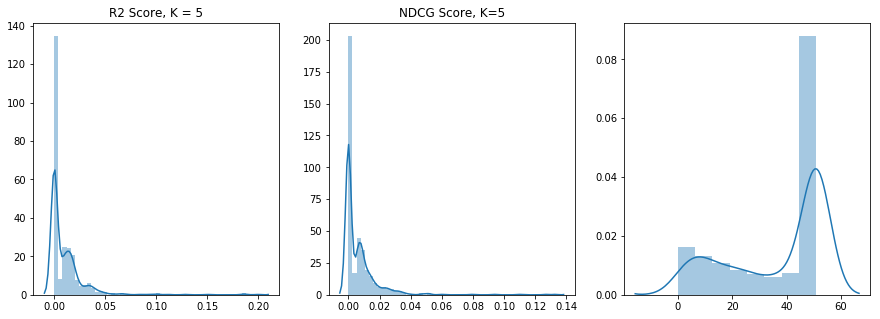

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))


sns.distplot(r2_acc, ax=ax1)
ax1.set_title('R2 Score, K = 5')

sns.distplot(nd_acc, ax=ax2)
ax2.set_title('NDCG Score, K=5')

sns.distplot(rsc_res, ax=ax3)

plt.show()

#### 2. Network: 

Letting $K$ be the number of seed songs, and $S$ be the number of remaining songs that we are trying to predict, we will evaluate the network model as follows. 

We will use $k = [1,5,10,25,100]$ (spotify challenge requirements) while setting $ 100 \leq S \leq 125$ in order to keep the number of tracts to predict relatively consistant in order to ensure that the changing numer of tracks doesn't affect the accuracy. The number of predicted songs will be a constant 500. 

In [31]:
def get_accuracies_from_network(k, network, start_block, blocks=10, min_remaining=50, max_remaining=150, 
                                num_samples = 1000, num_top_songs=500): 
    
    # build the prediction/remainder data
    predictors, remainders = build_evaluation_dataset(start_block, blocks=blocks, 
                                                      n_predictors=k, min_remaining=min_remaining, 
                                                      max_remaining=max_remaining)
    
    
    # get the predictions from the network
    predictions = []
    for i in range(len(predictors)): 
        p = [s[0] for s in n_top_songs(predictors[i], NETWORK, num_samples=num_samples, num_top_songs=num_top_songs)]
        predictions.append(p)
    
    # evaluate the model based on the 3 metrics 
    r_prec = RPrecision()
    r2_results = r_prec.evaluate(predictions, remainders, return_all=True)[1]
    
    ndcg_eval = NDCG()
    ndcg_results = ndcg_eval.evaluate(predictions, remainders, return_all=True)[1]
    
    rsc_eval = RSC()
    rsc_results = rsc_eval.evaluate(predictions, remainders, return_all=True)[1]
    
    
    return r2_results, ndcg_results, rsc_results
    
    
    

In [37]:
# sns.distplot(get_accuracies_from_network(5, NETWORK, 100))
r2_acc, nd_acc, rsc_res = get_accuracies_from_network(5, NETWORK, 10, blocks=2)

print (np.mean(r2_acc), np.mean(nd_acc), np.mean(rsc_res))

0.23548961346 0.189856332981 5.56868131868


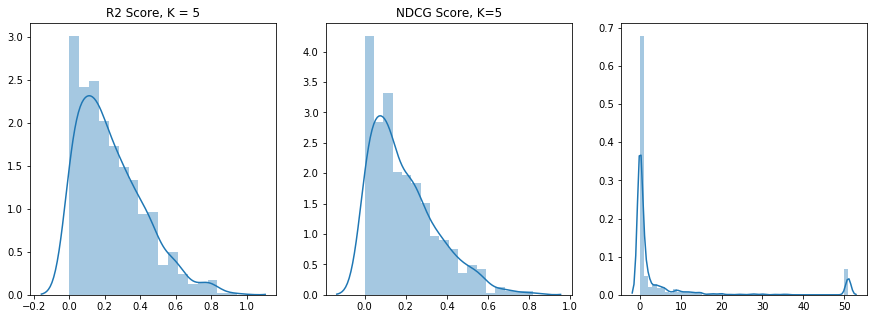

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))


sns.distplot(r2_acc, ax=ax1)
ax1.set_title('R2 Score, K = 5')

sns.distplot(nd_acc, ax=ax2)
ax2.set_title('NDCG Score, K=5')

sns.distplot(rsc_res, ax=ax3)

plt.show()

**3. Collaborative Filtering**

### Conclusions and Interpretations
Overall, we have seen that the filtering and network models perform the best, significantly improving over the baseline models using nearest neighbor techniques. Our final models were comparable with some of the top models in the RecSys challenge, so we are very satisfied with our results. If we had more time and computing power, we would have liked to scale both of those models up larger, as they were both limited in terms of their size (the network was trained on about 14000 playlists and ended up being about 7GB while filtering was only able to handle about **HOW MANY PLAYLISTS**). Ideally, we would be able to utilize sklearn's suppoer for sparse matrices to scale up filtering, but we weren't able to finalize that. 

Music recommendation in general is a challenging problem, with millions of songs to choose from and a large variety of songs within. More complex techniques like deep RNNs and autoencoders seemed attractive at the beginning of the project, but ultimately weren't feasible for us to complete. This forced us to adapt and implement the fairly different models seen here. Overall, we feel confident in our model's ability to find relevant songs to continue and put together a great playlist.